<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PEC1</p>
<p style="margin: 0; text-align:right;">2022-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 1: Redes neuronales artificiales y convolucionales con Keras

A lo largo de esta práctica vamos a implementar varios modelos de redes neuronales para clasificar las imágenes de una base de datos de imágenes satelitales. En concreto:
- Se implementará una red completamente conectada para establecer un modelo de referencia o <i>baseline</i>
- Se implementará una red convolucional
- Se implementará un autoencoder
- Se implementará una red convolucional profunda a partir de un modelo conocido (VGG16) pre-entrenado en Imagenet utilizando <i>transfer-learning</i>

<u>Consideraciones generales</u>: 

- La solución planteada no puede utilizar métodos, funciones o parámetros declarados **_deprecated_** en futuras versiones, a excepción de la carga de datos cómo se indica posteriormente.
- Esta PEC debe realizarse de forma **estrictamente individual**. Cualquier indicio de copia será penalizado con un suspenso (D) para todas las partes implicadas y la posible evaluación negativa de la asignatura de forma íntegra.
- Es necesario que el estudiante indique **todas las fuentes** que ha utilizado para la realización de la PEC. De no ser así, se considerará que el estudiante ha cometido plagio, siendo penalizado con un suspenso (D) y la posible evaluación negativa de la asignatura de forma íntegra.

<u>Formato de la entrega</u>:

- Algunos ejercicios pueden suponer varios minutos de ejecución, por lo que la entrega debe hacerse en **formato notebook** y en **formato html**, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a HTML desde el menú File $\to$ Download as $\to$ HTML.
- Existe un tipo de celda especial para albergar texto. Este tipo de celda os será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de la actividad. Para cambiar el tipo de celda a este tipo, en el menú: Cell $\to$ Cell Type $\to$ Markdown.

## 0. Contexto y carga de librerías
Las imágenes tomadas por satélite son clave en la supervisión del uso y la cobertura del suelo, cuestiones relevantes para la gestión ambiental, la planificación urbana, la sostenibilidad y para combatir el cambio climático.

En esta práctica, trabajaremos con la base de datos [UC Merced Land Use Data](http://weegee.vision.ucmerced.edu/datasets/landuse.html), que consiste en imágenes satelitales de 256x256 píxeles de 21 escenas diferentes: las clases son diversas, conteniendo escenas e imágenes de aviones o ríos, entre otras categorías.

Concretamente trabajaremos con una versión aumentada de dicha base de datos que está disponible en un [repositorio de Kaggle](https://www.kaggle.com/datasets/apollo2506/landuse-scene-classification). En esta versión se han llevado a cabo varios procesos de aumentación de datos de tal forma que el número de imágenes por clase pasa de 100 a 500.

**Nota: Se recomienda realizar la práctica en el entorno que ofrece la plataforma Kaggle, ya que ofrece un entorno gratuito con 30 horas semanales de uso de GPU.**

A lo largo de toda la práctica, para la creación de las distintas redes, iremos alternando el uso del modelo [Sequential](https://keras.io/guides/sequential_model/) y el modelo [Functional](https://keras.io/guides/functional_api/) de Keras a través de las clases [Sequential](https://keras.io/api/models/sequential/) y [Model](https://keras.io/api/models/model/) respectivamente.

Empezamos cargando las librerías mas relevantes:

In [2]:
# Importamos tensorflow
import tensorflow as tf
print("TF version   : ", tf.__version__)

# Necesitaremos GPU
print("GPU available: ", tf.config.list_physical_devices('GPU'))

# keras version is 2.11.0
import keras
print("Keras version   : ", keras.__version__)

TF version   :  2.11.0
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Keras version   :  2.11.0


In [3]:
# Importamos los elementos de keras que utilizaremos con mayor frecuencia
from keras.utils import image_dataset_from_directory
from keras.layers import (
    GlobalAveragePooling2D, Flatten,
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, 
    MaxPooling2D, UpSampling2D, Rescaling, Resizing)
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras import Sequential, Model

In [4]:
# Importamos el resto de librerías que necesitaremos para la PEC
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

## 1. Descarga, análisis y pre-procesado de los datos (1,5 puntos)

En este apartado exploraremos la base de datos y prepararemos la carga de las imágenes para los modelos de los siguientes apartados.

Para la descarga de la base de datos tenemos 2 opciones dependiendo de si decidimos trabajar en local o desde el entorno de Kaggle:
- Si trabajamos en local debemos descargar la base de datos desde el siguiente [enlace](https://www.kaggle.com/datasets/apollo2506/landuse-scene-classification/download?datasetVersionNumber=3) (es un archivo .zip que ocupa 2 GB) y descomprimirlo.
- Si trabajamos desde Kaggle. Debemos subir el Notebook del enunciado a la plataforma (para ello podéis seguir los 6 primeros pasos del siguiente [artículo](https://rajputankit22.medium.com/how-to-upload-my-own-notebook-to-kaggle-2b0dedbb5a6b)) y después, una vez subido el notebook, clickar el botón '+ Add Data' y en la caja de búsqueda introducir la dirección 'https://www.kaggle.com/datasets/apollo2506/landuse-scene-classification'. Una vez encontrado el dataset darle al botón '+' (Add Dataset), y desde ese momento ya tendréis accesible la base de datos en la ruta <code>../input/</code>.

Una vez tenemos la base de datos accesible vamos a inspeccionarla.

Las imágenes se encuentran agrupadas de 2 formas diferentes:
- En la carpeta <code>/landuse-scene-classification/images/</code> se encuentra el total de las imágenes separadas por clases (cada clase en una carpeta distinta). Pero no se ha realizado una separación en conjunto de entrenamiento y test (o entrenamiento, validación y test).
- En la carpeta <code>/landuse-scene-classification/images_train_test_val/</code> se encuentran 3 carpetas (<code>test</code>, <code>train</code> y <code>validation</code>) en las que el total de imágenes se ha separado de forma aleatoria. En cada una de las 3 carpetas, tenemos imágenes de las 21 clases agrupadas en sus correspondientes carpetas. En la carpeta raíz <code>/landuse-scene-classification/</code> tenemos 3 archivos .csv con la distribución de cada carpeta.

En esta práctica utilizaremos el dataset ya particionado, es decir, trabajaremos con las imágenes que se encuentran en la ruta <code>/landuse-scene-classification/images_train_test_val/</code>.

### 1.1. Análisis de los archivos .csv

A partir de los archivos .csv podemos ver cómo se han distribuído los datos. Por ejemplo:

In [5]:
train = pd.read_csv('../input/landuse-scene-classification/train.csv')
train.head(5)

,Unnamed: 0,Filename,Label,ClassName
0,5818,runway/runway_000259.png,16,runway
1,1327,intersection/intersection_000348.png,10,intersection
2,2529,agricultural/agricultural_000025.png,0,agricultural
3,3865,chaparral/chaparral_000195.png,5,chaparral
4,2024,airplane/airplane_000260.png,1,airplane


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio [0,5 pts.]:</strong> A partir de los 3 archivos .csv se pide:
    <ul>
        <li>Extraer los nombres de las 21 clases (esto sólo hace falta hacerlo en uno de los 3 archivos)</li>
        <li>¿Cuántas instancias tenemos en total para cada conjunto de datos?</li>
        <li>Comprobar que las clases están balanceadas en los 3 conjuntos de datos (contando para cada conjunto, cuantas instancias/ejemplos tenemos para cada clase)</li>
    </ul>        
</div>

In [6]:
# Extraer nombres de las clases

# Podemos ver las clases diferentes en el dataset de entrenamiento
clases = set(train.ClassName)

num_clases = len(clases)

print(clases)

{'chaparral', 'mediumresidential', 'forest', 'storagetanks', 'denseresidential', 'parkinglot', 'airplane', 'sparseresidential', 'beach', 'intersection', 'harbor', 'baseballdiamond', 'overpass', 'river', 'agricultural', 'runway', 'buildings', 'mobilehomepark', 'freeway', 'golfcourse', 'tenniscourt'}


Existen 21 clases diferentes de terrenos a intentar detectar

In [7]:
# Número de instancias por conjunto
path = '../input/landuse-scene-classification'

# Cargamos los otros datasets 
test = pd.read_csv(os.path.join(path,'test.csv'))
validation = pd.read_csv(os.path.join(path,'test.csv'))

print("Entrenamiento: " , len(train.index), "\n", 
     "Test: ", len(test.index), "\n", 
     "Validación: ", len(validation.index), "\n")

Entrenamiento:  7350 
 Test:  1050 
 Validación:  1050 



En el conjunto de entrenamiento tenemos 7350 instancias, en el test 1050 y en el de validación 2100

In [8]:
# Número de instancias por clase

# Contamos los datos y creamos un dataset
count_data = pd.concat([train.ClassName.value_counts(), 
                      test.ClassName.value_counts(), 
                      validation.ClassName.value_counts()],keys = ['Train','Test', 'Validation'],
                      axis=1)
count_data

,Train,Test,Validation
runway,350,50,50
baseballdiamond,350,50,50
parkinglot,350,50,50
beach,350,50,50
forest,350,50,50
mobilehomepark,350,50,50
river,350,50,50
sparseresidential,350,50,50
freeway,350,50,50
golfcourse,350,50,50


Se aprecia que tenemos 350 imágenes de cada clase en el conjunto de entrenamiento, 50 en el conjunto de test y 100 en el de validación.

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
Podemos apreciar que los datos están disbalanceados entre los 3 conjuntos, siendo mucho mayor los datos del conjunto de entrenamiento que los de validación y test. Sin embargo dentro de cada conjunto de datos, cada categoría está bien balanceada
<br><br> 
</div>

### 1.2. Análisis de las carpetas de imágenes.

Aunque se supone que cada archivo .csv refleja a la perfección el contenido de cada conjunto de datos, no está demás cerciorarse que el contenido del mismo se corresponde con lo anotado en cada archivo. Para ello se pide:

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio[0,5 pts]:</strong> Proporciona, a partir de las carpetas de imágenes, el número de imágenes que tenemos en cada categoría para cada conjunto de datos, comprobando que coincide con lo estipulado en el archivo .csv, y visualiza a modo de ejemplo una imagen por cada categoría. ¿Qué rango dinámico (valores mínimo y máximo) tienen las imágenes?
</div>

In [9]:
# Definimos las carpetas
images_folder = os.path.join(path, "images_train_test_val")
train_img_folder = os.path.join(images_folder, "train")


# Definimos una funcion que obtendrá el rango dinámico
def dyn_range(img_path):
    # Leemos las imágenes
    img = cv2.imread(img_path,cv2.IMREAD_ANYCOLOR )
    
    # Obtenemos la intensidad como la suma de los 3 canales
    bright = img.sum(axis=2)/3
    
    # Obtenemos el valor del rango dinámico 
    img_range = round(np.max(bright)- np.min(bright),2)
    return(img_range)

# Definimos una función que iterará en la carpeta y devuelve por cada clase
# El número de carpetas y el rango dinámico máximo de cada una de las imágenes

def map_n_print(fold_path):
    # Iteramos las diferentes carpetas
    sub_folders = glob.glob(os.path.join(fold_path, "*"))
    # Obtenemos la longitud de cada uno de ellos
    lista = list()
    rang = list()

    for fold in sub_folders:
        files = glob.glob(os.path.join(fold, "*"))
        lista.append(len(files))
        subrange = [dyn_range(im) for im in files]
        rang.append((max(subrange), min(subrange)))
        
    # Imprimimos en pantalla, obteniendo el nombre de la carpeta
    for name, length, rang in zip(sub_folders, lista, rang):
        print(os.path.basename(name), ":", length, ", dyn_range: max",rang[0], "min", rang[1])

map_n_print(train_img_folder)

airplane : 350 , dyn_range: max 255.0 min 154.67
tenniscourt : 350 , dyn_range: max 255.0 min 125.33
river : 350 , dyn_range: max 255.0 min 111.67
denseresidential : 350 , dyn_range: max 255.0 min 156.67
parkinglot : 350 , dyn_range: max 255.0 min 165.67
storagetanks : 350 , dyn_range: max 255.0 min 89.67
overpass : 350 , dyn_range: max 255.0 min 153.67
sparseresidential : 350 , dyn_range: max 255.0 min 156.67
mediumresidential : 350 , dyn_range: max 255.0 min 114.0
intersection : 350 , dyn_range: max 255.0 min 163.0
baseballdiamond : 350 , dyn_range: max 255.0 min 108.67
runway : 350 , dyn_range: max 255.0 min 131.67
chaparral : 350 , dyn_range: max 255.0 min 116.67
freeway : 350 , dyn_range: max 255.0 min 131.33
beach : 350 , dyn_range: max 255.0 min 88.67
buildings : 350 , dyn_range: max 255.0 min 148.0
harbor : 350 , dyn_range: max 255.0 min 128.67
mobilehomepark : 350 , dyn_range: max 255.0 min 146.33
forest : 350 , dyn_range: max 255.0 min 101.67
golfcourse : 350 , dyn_range: max

In [10]:
def plot_images(diccionario):
    # Creamos la figura
    plt.figure(1, figsize=(12, 9))
    plt.axis('off')
    
    # Iteramos los valores del diccionario que contendrá 
    # Por un lado el path y por otro el nombre de la carpeta
    for i, (k, value) in enumerate(diccionario.items()):
        n = i + 1
        # Leemos las imágenes
        imgs = cv2.imread(value, cv2.IMREAD_ANYCOLOR)
        
        # Representamos en cada punto la imagen
        plt.subplot(5,5,n)
        plt.title(k)
        plt.axis('off')
        plt.imshow(imgs)


def plot_random(fold_path):
    # Cargamos las librerías requeridas
    import random 
    
    # Mapeamos la carpeta
    sub_folders = glob.glob(os.path.join(train_img_folder, "*"))
    # Creamos un diccionario 
    selection = dict()
    
    # Escogemos de cada carpeta una imagen aleatoria
    for fold in sub_folders:
        images = glob.glob(os.path.join(fold, "*"))
        name = os.path.basename(fold)
        selection[name] = random.choice(images)
    
    plot_images(selection)


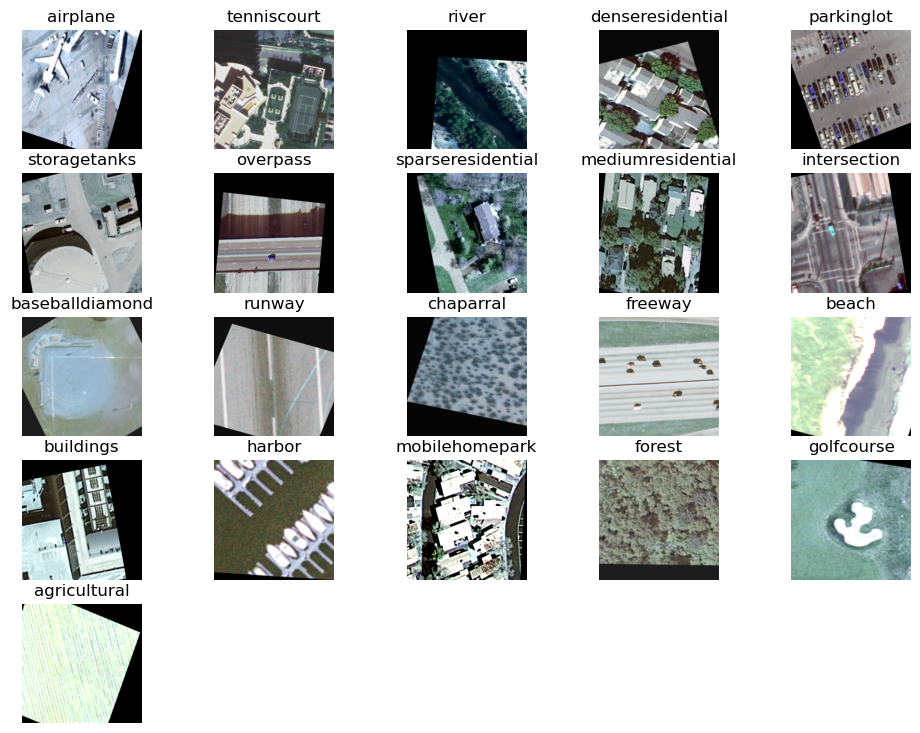

In [11]:
plot_random(train_img_folder)

In [12]:
# Para el conjunto de datos de validación
# Definimos la carpeta
val_img_folder = os.path.join(images_folder, "validation")

# Aplicamos la función
map_n_print(val_img_folder)

airplane : 100 , dyn_range: max 255.0 min 166.0
tenniscourt : 100 , dyn_range: max 255.0 min 141.33
river : 100 , dyn_range: max 255.0 min 157.0
denseresidential : 100 , dyn_range: max 255.0 min 154.33
parkinglot : 100 , dyn_range: max 255.0 min 182.33
storagetanks : 100 , dyn_range: max 255.0 min 154.33
overpass : 100 , dyn_range: max 255.0 min 182.33
sparseresidential : 100 , dyn_range: max 255.0 min 138.0
mediumresidential : 100 , dyn_range: max 255.0 min 186.33
intersection : 100 , dyn_range: max 255.0 min 171.67
baseballdiamond : 100 , dyn_range: max 255.0 min 162.67
runway : 100 , dyn_range: max 255.0 min 146.0
chaparral : 100 , dyn_range: max 255.0 min 133.0
freeway : 100 , dyn_range: max 255.0 min 129.0
beach : 100 , dyn_range: max 255.0 min 87.67
buildings : 100 , dyn_range: max 255.0 min 163.0
harbor : 100 , dyn_range: max 255.0 min 164.67
mobilehomepark : 100 , dyn_range: max 255.0 min 167.67
forest : 100 , dyn_range: max 255.0 min 148.0
golfcourse : 100 , dyn_range: max 255

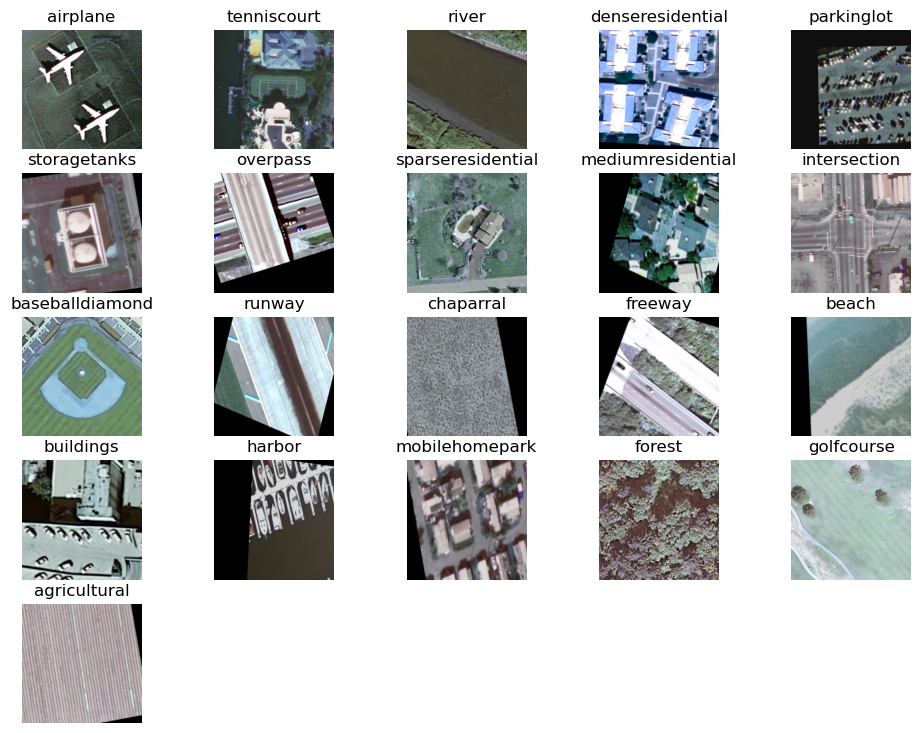

In [13]:
plot_random(val_img_folder)

In [14]:
# Para el conjunto de datos de test

# Definimos la carpeta
test_img_folder = os.path.join(images_folder, "test")

# Aplicamos la función
map_n_print(test_img_folder)

airplane : 50 , dyn_range: max 255.0 min 181.33
tenniscourt : 50 , dyn_range: max 255.0 min 164.67
river : 50 , dyn_range: max 255.0 min 156.33
denseresidential : 50 , dyn_range: max 255.0 min 154.0
parkinglot : 50 , dyn_range: max 255.0 min 191.67
storagetanks : 50 , dyn_range: max 255.0 min 168.33
overpass : 50 , dyn_range: max 255.0 min 185.33
sparseresidential : 50 , dyn_range: max 255.0 min 179.67
mediumresidential : 50 , dyn_range: max 255.0 min 163.0
intersection : 50 , dyn_range: max 255.0 min 162.67
baseballdiamond : 50 , dyn_range: max 255.0 min 165.0
runway : 50 , dyn_range: max 255.0 min 147.33
chaparral : 50 , dyn_range: max 255.0 min 134.0
freeway : 50 , dyn_range: max 255.0 min 174.0
beach : 50 , dyn_range: max 255.0 min 84.33
buildings : 50 , dyn_range: max 255.0 min 166.67
harbor : 50 , dyn_range: max 255.0 min 178.0
mobilehomepark : 50 , dyn_range: max 255.0 min 161.0
forest : 50 , dyn_range: max 255.0 min 154.0
golfcourse : 50 , dyn_range: max 255.0 min 118.67
agricu

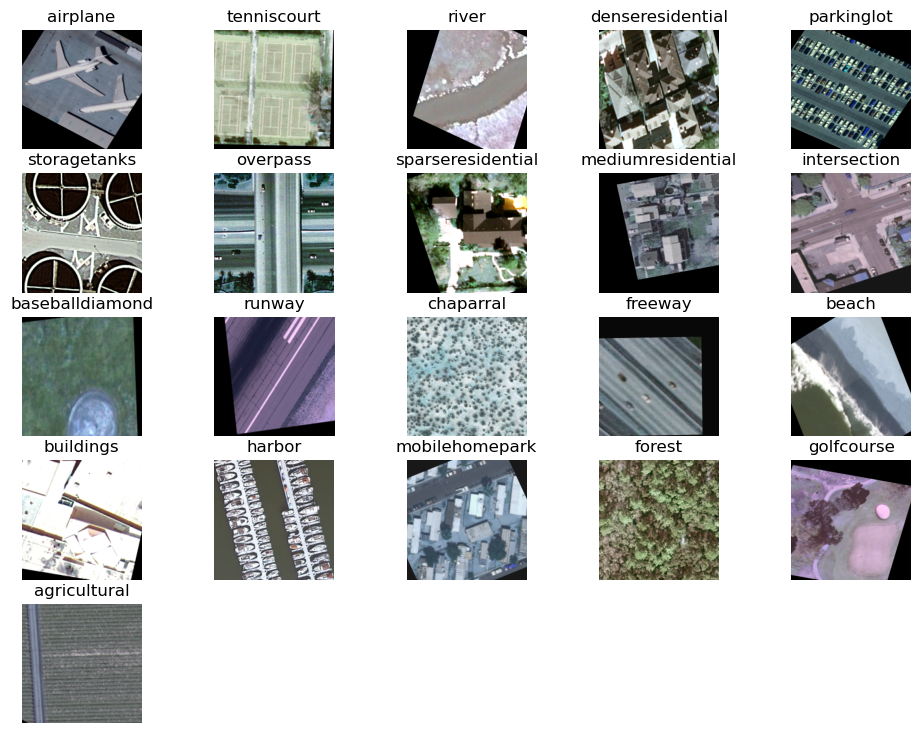

In [15]:
plot_random(test_img_folder)

### 1.3. Creación de los conjuntos de datos en formato Keras/Tensorflow
​
Con el objetivo de crear una base de datos en el formato Keras/Tensorflow a partir de las imágenes proporcionadas utilizaremos la función <code>**tf.keras.utils.image_dataset_from_directory()**</code> ya que nos permite crear bases de datos a partir de imágenes guardadas en carpetas.

La documentación de esta función se encuentra tanto en la web de [Keras](https://keras.io/api/data_loading/image/) como en la de [Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) .

Además, aprovecharemos para redimensionar las imágenes y pasarlas a tamaño 224x224, que es el tamaño con el que se ha entrenado la red VGG16 que utilizaremos en un apartado posterior.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio[0,5 pts]:</strong> Utiliza la función  <code>image_dataset_from_directory()</code> para generar 3 conjuntos de datos (<code>train_data</code>, <code>val_data</code> y <code>test_data</code>) a partir de las carpetas analizadas. Las imágenes deben ser redimensionadas a tamaño 224x224 píxels RGB (224,224,3) y agrupadas en lotes de tamaño 32 (batch=32) manteniendo su rango dinámico.
</div>

In [16]:
img_size = (224,224,3)
b_size = 32
l_rate = 0.0001

train_data = image_dataset_from_directory(train_img_folder, 
                                          image_size = img_size[:2],
                                          batch_size=b_size)
test_data = image_dataset_from_directory(test_img_folder, 
                                          image_size = img_size[:2],
                                          batch_size=b_size)
val_data = image_dataset_from_directory(val_img_folder, 
                                          image_size = img_size[:2],
                                          batch_size=b_size)

Found 7350 files belonging to 21 classes.
Found 1050 files belonging to 21 classes.
Found 2100 files belonging to 21 classes.


## 2. Modelo ANN (1,5 puntos)

En este apartado, vamos a entrenar y evaluar un modelo muy sencillo completamente conectado para establecer un resultado de referencia.

Dado que en una red neuronal artificial las entradas son unidimensionales, lo primero que tenemos que hacer es redimensionar los datos de entrada (las imágenes) para convertirlos en arrays de una dimensión.

Como trabajar con imágenes de tamaño 224x224 en una red completamente conectada implicaría entrenar un número de parámetros excesivamente elevado definiremos un modelo en el que se realizará previamente un redimensionado de las imágenes de entrada a un tamaño de 32x32 y un achatamiento (*flattening*) de los píxeles para así generar un vector unidimensional de tamaño 3072 (32x32x3). 

Posteriormente entrenaremos un clasificador (una red completamente conectada) para llevar a cabo la clasificación de nuestros datos.

En este apartado utilizaremos las capas [Resizing](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/resizing/), [Rescaling](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/), [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/), [Dense](https://keras.io/api/layers/core_layers/dense/) y [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) de keras.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio:</strong> Implementa un modelo <strong>secuencial</strong> de Keras (a partir de la clase <code>Sequential()</code>) con las siguientes especificaciones:
    <ul>
        <li>Una capa que reduzca las dimensiones de entrada de (224,224) a (32,32)</li>
        <li>Una capa de reescalado para conseguir que los valores de la imagen estén entre 0 y 1</li>
        <li>Una capa Flatten para convertir la imagen en un vector de 3072 posiciones</li>
        <li>Una capa completamente conectada de 1024 neuronas y activación ReLU</li>
        <li>Una capa de Dropout (con probabilidad 0.5)</li>
        <li>Una capa de salida completamente conectada correspondiente a la clasificación final cuyo número de neuronas debe ser igual al múmero de clases de la base de datos y con la función de activación adecuada para llevar a cabo esta tarea de clasificación.</li>
    </ul>
        
Compilar y entrenar el modelo siguiendo las siguientes indicaciones:
     <ul>
         <li>Utilizar el optimizador Adam con  <i>learning rate</i> de 0.0001.</li>
         <li>Entrenar durante 100 épocas utilizando  <i>EarlyStopping</i> con una persistencia de 10 épocas, monitorizando la función de pérdida en el conjunto de validación, y guardando los pesos que mejor resultado hayan obtenido.</li>
         <li>Monitorizar la métrica  <i>accuracy</i> durante entrenamiento y validación.</li>
         <li>Mostrar las gráficas de accuracy y loss. En cada gráfica debe visualizarse la curva de entrenamiento y la de validación. NOTA: Se recomienda hacer una función que imprima ambas gráficas para poder reutilizarla en próximos apartados.</li>
         <li>Realizar la evaluación del modelo una vez ha finalizado el entrenamiento para mostrar la pérdida y la precisión final sobre los datos de test.</li>
    </ul>
    Preguntas a responder: ¿Cúal es el número de parámetros a entrenar? ¿y el tiempo de entrenamiento? ¿Qué precisión se obtiene con este modelo? Comenta los resultados.<br/>    
    <strong> NOTA: se recomienda, al final de la creación de cada modelo, utilizar la función <code>summary()</code> para comprobar la estructura de la red creada, así como el numero de parámetros que se deben entrenar. Se recomienda hacerlo en todos los ejercicios.</strong>
</div>

In [63]:
# Definición de la red

# Generamos un modelo secuencial
model = Sequential()
# En la capa de entrada redimensionamos las imágenes
model.add(Resizing(32,32, input_shape=img_size))
# Posteriormente reescalamos las imágenes
model.add(Rescaling(1./255))
# Realizamos un flatten de las diferentes capas
model.add(Flatten())
# Definimos la capa fully connected con 1024 neuronas
model.add(Dense(units=1024, activation="relu", # Función de activación ReLU
                kernel_initializer="random_normal", # Iniciamos los pesos normal para acelerar
                                                    # el entrenamiento
                bias_initializer="zeros"))
# Definimos el drop out 
model.add(Dropout(rate=.5))
# Definimos la capa de salida según las clases definidas
# Especificamos que la función sea softmax para determinar las probabilidades
model.add(Dense(units=num_clases, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 3)         0         
                                                                 
 rescaling_4 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              3146752   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 21)                21525     
                                                                 
Total params: 3,168,277
Trainable params: 3,168,277
No

In [64]:
# Compilación de la red
model.compile(optimizer=Adam(learning_rate=l_rate),
              loss='sparse_categorical_crossentropy',# Definimos la función de pérdida
              metrics=['accuracy'] # Definimos las métricas
             )

call = EarlyStopping(monitor='val_loss', # Definimos la metrica a monitorizar
                     patience=10, # Definimos la paciencia
                     verbose=0, # Mostramos si se produce un callback
                     min_delta=0.1 # Definimos cuanto consideramos una mejoría
                    )

In [65]:
%%time
# Entrenamiento de la red
history = model.fit(train_data, validation_data = val_data, epochs=100, 
                    callbacks=[call])


Epoch 1/100
230/230 [==============================] - 26s 107ms/step - loss: 3.2561 - accuracy: 0.0691 - val_loss: 2.9728 - val_accuracy: 0.0924
Epoch 2/100
230/230 [==============================] - 25s 108ms/step - loss: 2.9680 - accuracy: 0.0969 - val_loss: 2.9244 - val_accuracy: 0.1300
Epoch 3/100
230/230 [==============================] - 24s 104ms/step - loss: 2.9071 - accuracy: 0.1207 - val_loss: 2.8988 - val_accuracy: 0.1329
Epoch 4/100
230/230 [==============================] - 25s 107ms/step - loss: 2.8621 - accuracy: 0.1401 - val_loss: 2.8686 - val_accuracy: 0.1390
Epoch 5/100
230/230 [==============================] - 23s 100ms/step - loss: 2.8059 - accuracy: 0.1533 - val_loss: 2.8269 - val_accuracy: 0.1538
Epoch 6/100
230/230 [==============================] - 24s 102ms/step - loss: 2.7560 - accuracy: 0.1743 - val_loss: 2.8028 - val_accuracy: 0.1586
Epoch 7/100
230/230 [==============================] - 29s 125ms/step - loss: 2.7004 - accuracy: 0.1921 - val_loss: 2.7772 -

In [22]:
# Plot del training loss i l'accuracy

def plot_history(historial):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    ax1.plot(historial.history['accuracy'])
    ax1.plot(historial.history['val_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'validation'], loc='lower right')


    # Visualizamos la evolución del error cometido por la red
    ax2.plot(historial.history['loss'])
    ax2.plot(historial.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper right')
    
    plt.show()

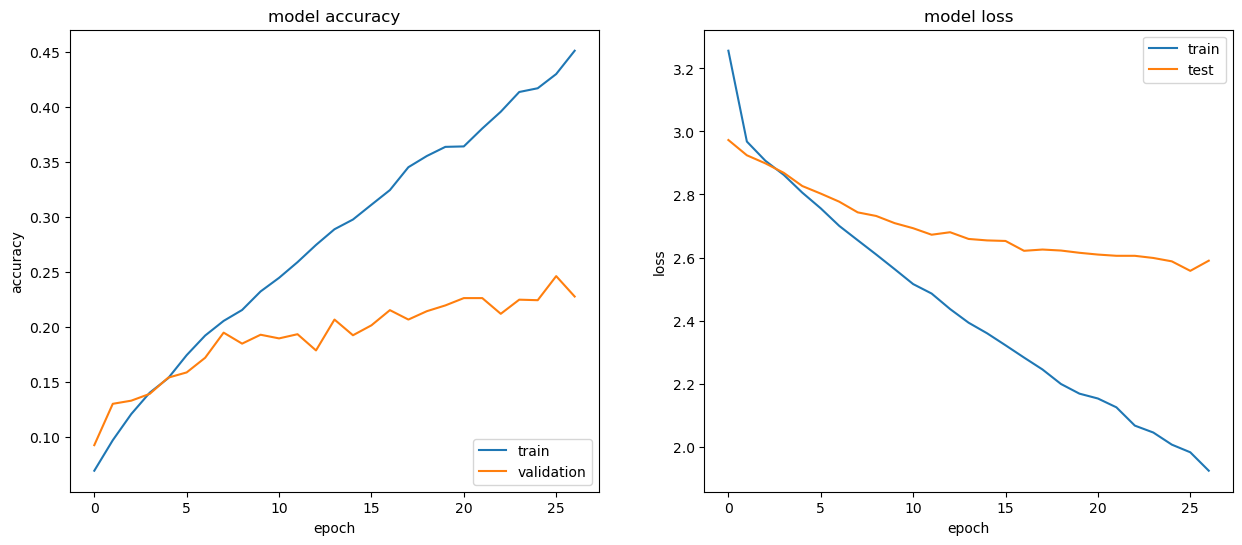

In [66]:
# Llamamos a la función previamente creada
plot_history(history)

In [67]:
# Evaluamos el modelo 
score = model.evaluate(test_data, verbose=0)

print("En los datos de test la función de pérdida es {} y en la precisión es {}, respectivamente"
      .format(round(score[0],2), round(score[1],2)))

En los datos de test la función de pérdida es 2.6 y en la precisión es 0.22, respectivamente


In [68]:
def show_confusion_matrix(modelo, data):
    # Extraemos las categorías del modelo 
    labels = np.concatenate([y for x, y in data], axis=0)
    
    # Predecimos con los datos del test
    classes = np.argmax(modelo.predict(data), axis=1)
    
    # Creamos la tabla de contingencia
    cm = (pd.crosstab(pd.Series(labels, name='Real'), 
                      pd.Series(classes, name='Predicho'))
            .style.background_gradient('binary'))
    return cm

# Llamamos a la función
show_confusion_matrix(model, test_data)

33/33 [==============================] - 3s 71ms/step


Predicho,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Real,,,,,,,,,,,,,,,,,,,,,
0,2,0,1,6,1,3,2,4,4,5,2,0,0,1,2,5,0,4,3,3,2
1,4,3,1,2,5,4,2,2,1,7,2,1,0,1,2,1,3,3,2,2,2
2,1,1,2,2,3,3,4,2,3,9,2,3,0,1,1,3,3,2,2,2,1
3,3,4,1,2,0,4,2,0,2,4,3,2,0,2,4,0,3,3,4,6,1
4,0,1,2,5,3,1,1,4,5,11,4,1,0,1,2,1,3,1,1,2,1
5,2,2,3,3,2,3,0,4,3,7,4,1,0,0,3,2,0,0,3,5,3
6,2,2,4,4,1,0,1,2,3,6,2,0,0,1,2,4,2,1,1,8,4
7,3,2,3,6,0,4,3,3,3,2,0,1,0,0,2,2,4,2,2,5,3
8,0,2,2,6,0,4,1,2,1,5,6,1,0,1,3,2,5,3,1,2,3


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
¿Cuál es el número de parámetros a entrenar? Esto lo podemos ver en el summary del modelo, donde se especifica que son necesarios para el entrenamiento 3,168,277 parámetros en total. 
<br><br>
¿Y el tiempo de entrenamiento? El tiempo de entrenamiento ronda los 12 minutos, ya que el modelo tiene sobreajuste y se realiza una finalización precoz del entrenamiento al no mejorar. 
<br><br>
¿Cuál es la precisión del modelo? Vemos que la precisión en los datos de test es bastante mala (peor incluso que lanzar una moneda al aire)
<br><br>
En resumen, podemos decir que este modelo peca de estar sobreajustado a los datos, además de ser bastante lento de entrenar, ya que requiere más de 3 millones de parámetros para entrenar, por lo que no es el modelo que estamos buscando. El sobreajuste lo podemos apreciar en las gráficas que hemos representado, donde se aprecia como en los datos de entrenamiento va aumentando la precisión y disminuyendo la pérdida, no siendo así para los datos de validación  
</div>

## 3. Red convolucional pequeña (2 puntos)

Dadas las bajas prestaciones del modelo anterior vamos a probar otro tipo de redes con el objetivo de obtener unos mejores resultados en la tarea de clasificación que debemos llevar a cabo.

Las redes convolucionales (CNN) son especialmente adecuadas para modelar datos donde hay patrones en 2 dimensiones, como es el caso de las imágenes.

En la tarea de clasificación, la estructura de una CNN se divide en dos grandes bloques:

* **Bloque extractor de características**: En este bloque se generan diferentes niveles de abstracción de la imagen de entrada mediante capas convolucionales. Cuanto más profundas son estas capas, más preparadas están para la tarea de clasificación.
* **Clasificador**: Este bloque está formado por capas totalmente conectadas, la salida de deste bloque será la probabilidad asociada a cada clase.

En el apartado anterior, el bloque "extractor de características" era extremadamente simple, por no decir inexistente. En este apartado, vamos a hacer uso de capas convolucionales para poder aprender mejores abstracciones de las imágenes de entrada con el fin de mejorar su clasificación.

En este apartado utilizaremos las capas [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/),  [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/), [GlobalAveragePooling2D](https://keras.io/api/layers/pooling_layers/global_average_pooling2d/), [Dense](https://keras.io/api/layers/core_layers/dense/) y [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) de keras.

**Nota: Se recomienda, a partir de este punto realizar el entrenamiento en una máquina con GPU (puede activarse en plataformas como Google Colab o Kaggle) con el fin de reducir los tiempos de entrenamiento.**

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio [2 puntos]:</strong> A partir del modelo <strong>funcional</strong> de keras (y la clase <code>Model()</code>), implementa una red con las siguientes características:
    <ul>
        <li>Un bloque extractor de características que conste de:
            <ul>
                <li>Una capa de entrada de dimensiones adecuadas a los datos.</li>
                <li>Una capa de rescalado para conseguir que los valores de la imagen estén entre 0 y 1.</li>
                <li>3 capas convolucionales con tamaño de kernel (5x5) para la primera y (3x3) para las 2 siguientes. Se utilizará padding '<i>same</i>' y activación ReLU. El número de filtros para cada capa convolucional será 16, 32 y 64 respectivamente.</li>
                <li>A cada capa convolucional le sigue una capa de <i>Max Pooling</i></li>
                <li>Una capa de <i>average pooling</i> (GlobalAveragePooling2D) para reducir las dimensiones a un vector de 1024 dimensiones.</li>
            </ul></li>
        <li>El clasificador final sigue la estructura del modelo del apartado anterior:
            <ul>
                <li>Una capa completamente conectada de 1024 neuronas y activación ReLU</li>
                <li>Una capa de Dropout (con probabilidad 0.5)</li>
                <li>Una capa de salida completamente conectada correspondiente a la clasificación final cuyo número de neuronas debe ser igual al múmero de clases de la base de datos y con la función de activación adecuada para llevar a cabo esta tarea de clasificación.</li>
            </ul></li>
    </ul>
    
Compilar y entrenar el modelo siguiendo las siguientes indicaciones:
     <ul>
         <li>Utilizar el optimizador Adam con  <i>learning rate</i> de 0.001.</li>
          <li>Entrenar durante 100 épocas utilizando  <i>EarlyStopping</i> con una persistencia de 10 épocas, monitorizando la función de pérdida en el conjunto de validación, y guardando los pesos que mejor resultado hayan obtenido.</li>
         <li>Monitorizar la métrica  <i>accuracy</i> durante entrenamiento y validación.</li>
         <li>Mostrar las gráficas de <i>accuracy</i> y <i>loss</i>. En cada gráfica debe visualizarse la curva de entrenamiento y la de validación.</li>
         <li>Realizar la evaluación del modelo una vez ha finalizado el entrenamiento para mostrar la pérdida y la precisión final sobre los datos de test.</li>
    </ul>
    Preguntas a responder: ¿Cúal es el número de parámetros a entrenar? ¿y el tiempo de entrenamiento? ¿Qué precisión se obtiene con este modelo? Comenta los resultados.
</div>

In [69]:
# Definición de la red

# Definimos la entrada de la red
layer_input = keras.Input(shape=img_size)
# Definimos una capa de reescalado
layer_rescale = Rescaling(1./255)(layer_input)
# Tenemos una capa convolucional de 16 filtros de 5x5 con activación ReLU
layer_conv1 = Conv2D(16,(5,5), padding="same", activation="relu")(layer_rescale)
layer_max1 = MaxPooling2D()(layer_conv1)
# Tenemos una capa convolucional de 32 filtros de 3x3 con activación ReLU
layer_conv2 = Conv2D(32,(3,3), padding="same", activation="relu")(layer_max1)
layer_max2 = MaxPooling2D()(layer_conv2)
# Tenemos una capa convolucional de 64 filtros de 3x3 con activación ReLU
layer_conv3 = Conv2D(64,(3,3), padding="same", activation="relu")(layer_max2)
layer_max3 = MaxPooling2D()(layer_conv3)
# Llamamos a una capa de pooling average
layer_avg = GlobalAveragePooling2D()(layer_max3)
# El resto de capas son similares al anterior modelo
layer_full = Dense(units=1024, activation="relu",
                kernel_initializer="random_normal", 
                bias_initializer="zeros")(layer_avg)
layer_drop = Dropout(rate=.5)(layer_full)
layer_out = Dense(units=num_clases, activation="softmax")(layer_drop)

model = Model(inputs=layer_input, outputs=layer_out, name="cnn_model")
model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_5 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 16)      1216      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                     

In [70]:
# Compilación de la red

# Usamos parámetros similares
model.compile(optimizer=Adam(learning_rate=l_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
             )

call = EarlyStopping(monitor='val_loss', 
                     patience=10, # Definimos la paciencia
                     verbose=1, # Mostramos si se produce un callback
                     restore_best_weights = True, 
                     min_delta=0.01, # Definimos cuanto consideramos una mejoría
                     mode="min")

In [71]:
%%time
# Entrenamiento

# Entrenamiento de la red
history = model.fit(train_data, validation_data = val_data, epochs=100, 
                    callbacks=[call])

Epoch 1/100
230/230 [==============================] - 27s 109ms/step - loss: 3.0278 - accuracy: 0.0631 - val_loss: 2.9679 - val_accuracy: 0.1052
Epoch 2/100
230/230 [==============================] - 26s 110ms/step - loss: 2.8271 - accuracy: 0.1239 - val_loss: 2.7198 - val_accuracy: 0.1333
Epoch 3/100
230/230 [==============================] - 27s 115ms/step - loss: 2.6896 - accuracy: 0.1411 - val_loss: 2.6396 - val_accuracy: 0.1610
Epoch 4/100
230/230 [==============================] - 25s 108ms/step - loss: 2.6224 - accuracy: 0.1646 - val_loss: 2.5744 - val_accuracy: 0.1981
Epoch 5/100
230/230 [==============================] - 25s 108ms/step - loss: 2.5599 - accuracy: 0.1899 - val_loss: 2.5245 - val_accuracy: 0.2157
Epoch 6/100
230/230 [==============================] - 25s 106ms/step - loss: 2.5097 - accuracy: 0.2065 - val_loss: 2.4869 - val_accuracy: 0.2286
Epoch 7/100
230/230 [==============================] - 26s 109ms/step - loss: 2.4737 - accuracy: 0.2137 - val_loss: 2.4455 -

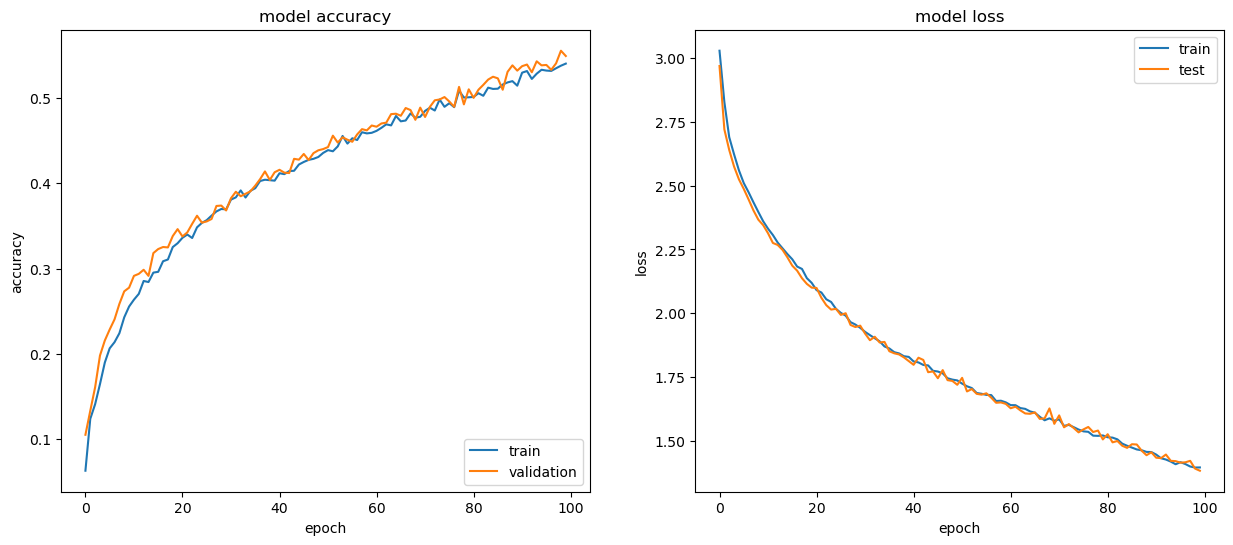

In [72]:
# Resultados

# Representamos los datos
plot_history(history)

In [73]:
# Evaluamos el modelo 
score = model.evaluate(test_data, verbose=0)

print("En los datos de test la función de pérdida es {} y en la precisión es {}, respectivamente"
      .format(round(score[0],2), round(score[1],2)))

En los datos de test la función de pérdida es 1.34 y en la precisión es 0.54, respectivamente


In [80]:
show_confusion_matrix(model, test_data)

33/33 [==============================] - 3s 65ms/step


Predicho,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Real,,,,,,,,,,,,,,,,,,,,,
0,0,4,2,7,2,3,1,1,2,1,2,4,3,2,2,3,0,8,2,0,1
1,4,4,3,2,1,2,2,3,4,2,2,1,2,3,3,2,3,4,0,0,3
2,2,2,1,3,1,2,5,3,3,3,2,2,2,2,6,2,3,4,1,0,1
3,6,2,1,2,0,3,3,3,3,2,2,0,2,2,2,3,2,4,5,2,1
4,4,4,4,3,2,2,3,2,3,2,0,0,1,4,0,3,5,3,1,3,1
5,4,1,1,5,4,1,6,1,2,2,2,3,3,2,3,1,2,3,2,2,0
6,3,5,2,1,0,3,4,1,4,3,3,2,4,1,3,3,1,2,1,2,2
7,4,1,1,3,5,2,4,1,0,4,1,2,2,2,7,2,2,4,1,0,2
8,5,4,1,4,1,4,3,2,1,1,2,2,1,2,4,4,3,3,1,0,2


In [77]:
test_data.classes

['agricultural',
 'airplane',
 'baseballdiamond',
 'beach',
 'buildings',
 'chaparral',
 'denseresidential',
 'forest',
 'freeway',
 'golfcourse',
 'harbor',
 'intersection',
 'mediumresidential',
 'mobilehomepark',
 'overpass',
 'parkinglot',
 'river',
 'runway',
 'sparseresidential',
 'storagetanks',
 'tenniscourt']

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
Vemos que en este caso el modelo ha mejorado de forma sustancial, aunque sigue teniendo problemas a la hora de predecir los datos. Si bien con este nuevo modelo hemos solucionado el problema del sobreajuste, la precisión del modelo sigue siendo baja. 
    
El número de parámetros a entrenar se ha reducido de forma importante desde los 5 millones de parámetros a los 112.437 parámetros que requiere el modelo convolucional.
    
Además el tiempo de entrenamiento en este caso se ha visto aumentado (hasta los 45 min de entrenamiento), pero esto puede tener que ver principalmente con el hecho de que al no existir el sobreajuste, el modelo completa todas las épocas sin realizar una finalización precoz del entrenamiento
    
Sin embargo, el modelo no tiene una precisión muy alta a la hora de predecir los datos todavía. Es posible que aumentando más el número de épocas el modelo siguiera mejorando 
<br><br>
</div>

## 4. Autoencoders (2 puntos)

En el apartado anterior hemos podido observar que, utilizando el tipo de redes adecuado, podemos obtener mejores resultados entrenando un número de parámetros muy inferior. Esto es debido a que las CNN consiguen extraer las características principales de los datos proporcionados (imágenes en nuestro caso).

En este apartado vamos a observar esta capacidad desde otro punto de vista: el de **codificar y decodificar una imagen**.

Para ello diseñaremos un autoencoder que sea capaz de reducir el tamaño de los datos de entrada pero captando las características principales de las imágenes para poder llevar a cabo una buena reconstrucción de las mismas.

Empezaremos rescalando externamente los datos que vamos a utilizar, para que estén en el rango (0,1), en lugar de realizarlo dentro de la red como hemos hecho en el apartado anterior:

In [78]:
# data rescalling
normalization_layer = Rescaling(1./255)

normalized_train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
normalized_val_data = val_data.map(lambda x, y: (normalization_layer(x), y))

Además, en un autoencoder, en lugar de utilizar las etiquetas como objetivo (que es lo que se utiliza en un problema de clasificación), deben ser las propias imágenes las que se utilicen como objetivo de la red. Por tanto, crearemos una nueva base de datos de entrenamiento y validación donde son las propias imágenes las que hagan de etiquetas:

In [79]:
train_data_auto = normalized_train_data.map(lambda x, y: (x, x))
val_data_auto = normalized_val_data.map(lambda x, y: (x, x))

Comprobamos la estructura de la nueva base de datos:

In [81]:
image_batch, label_batch = iter(train_data_auto).get_next()
print("Las dimensiones de un batch de imágenes es: {}".format(image_batch.shape))
print("Las dimensiones de un batch de etiquetas es: {}".format(label_batch.shape))

Las dimensiones de un batch de imágenes es: (32, 224, 224, 3)
Las dimensiones de un batch de etiquetas es: (32, 224, 224, 3)


Y que los datos tienen el rango dinámico adecuado:

In [82]:
first_image = image_batch[0]
print("En la primera imagen los valores mínimo y máximo son {} y {}, respectivamente"
      .format(np.min(first_image),np.max(first_image)))

En la primera imagen los valores mínimo y máximo son 0.17995193600654602 y 1.0, respectivamente


### 4.1. Diseño y entrenamiento del autoencoder

Una vez ya tenemos los datos en el formato adecuado vamos a diseñar el autoencoder. Para ello utilizaremos el bloque extractor del apartado anterior como codificador y reflejaremos su estructura en el decodificador utilizando las capas [Conv2DTranspose](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/) y [UpSampling2D](https://keras.io/api/layers/reshaping_layers/up_sampling2d/) de keras.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio [1 punto]:</strong> A partir del modelo <strong>funcional</strong> de keras (y la clase <code>Model()</code>), implementa un autoencoder con las siguientes características:
    <ul>
        <li>El bloque codificador debe tener:
            <ul>
                <li>Una capa de entrada de dimensiones adecuadas a los datos.</li>
                <li>3 capas convolucionales con tamaño de kernel (5x5) para la primera y (3x3) para las 2 siguientes. Se utilizará padding '<i>same</i>' y activación ReLU. El número de filtros para cada capa convolucional será 16, 32 y 64 respectivamente.</li>
                <li>A cada capa convolucional le sigue una capa de <i>Max Pooling</i></li>
            </ul></li>
        <li>El bloque decodificador debe tener:
            <ul>
                <li>3 capas convolucionales con tamaño de kernel (3x3) para las 2 primeras y (5x5) para la última. Se utilizará padding '<i>same</i>' y activación ReLU. El número de filtros para cada capa convolucional será 64, 32 y 16, respectivamente</li>
                <li>A cada capa convolucional le sigue una capa de <i>UpSampling2D</i></li>
                <li>Una última capa convolucional con tamaño de kernel (3x3), con 3 filtros y activación sigmoide.</li>
            </ul></li>
    </ul>
    
Compilar y entrenar el modelo siguiendo las siguientes indicaciones:
     <ul>
         <li>Utilizar el optimizador Adam con  <i>learning rate</i> de 0.001.</li>
         <li>Utilizar como función de pérdida el error cuadrático medio.</li>
         <li>Entrenar durante 100 épocas utilizando  <i>EarlyStopping</i> con una persistencia de 10 épocas, monitorizando la función de pérdida en el conjunto de validación, y guardando los pesos que mejor resultado hayan obtenido.</li>
         <li>Monitorizar la pérdida durante entrenamiento y validación.</li>
         <li>Mostrar las gráficas del <i>loss</i> (la curva de entrenamiento y la de validación).</li>
    </ul>
</div>



In [84]:
# Definición de la red

# Definimos la entrada de la red
layer_input = keras.Input(shape=img_size)
# Parte encoder
layer_conv1 = Conv2D(16,(5,5), padding="same", activation="relu")(layer_input)
layer_max1 = MaxPooling2D()(layer_conv1)
layer_conv2 = Conv2D(32,(3,3), padding="same", activation="relu")(layer_max1)
layer_max2 = MaxPooling2D()(layer_conv2)
layer_conv3 = Conv2D(64,(3,3), padding="same", activation="relu")(layer_max2)
layer_max3 = MaxPooling2D()(layer_conv3)
# Parte decoder
layer_conv4 = Conv2DTranspose(64,(3,3), padding="same", activation="relu")(layer_max3)
layer_max4 = UpSampling2D()(layer_conv4)
layer_conv5 = Conv2DTranspose(32,(3,3), padding="same", activation="relu")(layer_max4)
layer_max5 = UpSampling2D()(layer_conv5)
layer_conv6 = Conv2DTranspose(16,(5,5), padding="same", activation="relu")(layer_max5)
layer_max6 = UpSampling2D()(layer_conv6)
# Capa externa
layer_out = Conv2D(3,(3,3), padding="same", activation="sigmoid")(layer_max6)

model = Model(inputs=layer_input, outputs=layer_out, name="encoder")
model.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 16)      1216      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 56, 56, 64)        1849

In [85]:
# Compilación de la red

model.compile(optimizer=Adam(learning_rate=l_rate),
              loss='mean_squared_error',
              metrics=['accuracy']
             )

call = EarlyStopping(monitor='val_loss', 
                     patience=10, # Definimos la paciencia
                     verbose=1, # Mostramos si se produce un callback
                     restore_best_weights=True, # Restaura el mejor modelo
                     min_delta=0.1, # Definimos cuanto consideramos una mejoría
                     mode="min")

In [86]:
%%time
# Entrenamiento de la red

# Entrenamiento de la red
history = model.fit(train_data_auto, validation_data = val_data_auto, epochs=100, 
                    callbacks=[call])

Epoch 1/100
230/230 [==============================] - 35s 144ms/step - loss: 0.0316 - accuracy: 0.3874 - val_loss: 0.0125 - val_accuracy: 0.4460
Epoch 2/100
230/230 [==============================] - 30s 128ms/step - loss: 0.0106 - accuracy: 0.5663 - val_loss: 0.0091 - val_accuracy: 0.6229
Epoch 3/100
230/230 [==============================] - 30s 127ms/step - loss: 0.0086 - accuracy: 0.6405 - val_loss: 0.0081 - val_accuracy: 0.6528
Epoch 4/100
230/230 [==============================] - 34s 145ms/step - loss: 0.0078 - accuracy: 0.6537 - val_loss: 0.0073 - val_accuracy: 0.6563
Epoch 5/100
230/230 [==============================] - 29s 122ms/step - loss: 0.0073 - accuracy: 0.6606 - val_loss: 0.0069 - val_accuracy: 0.6655
Epoch 6/100
230/230 [==============================] - 33s 142ms/step - loss: 0.0069 - accuracy: 0.6627 - val_loss: 0.0065 - val_accuracy: 0.6612
Epoch 7/100
230/230 [==============================] - 29s 126ms/step - loss: 0.0065 - accuracy: 0.6641 - val_loss: 0.0062 -

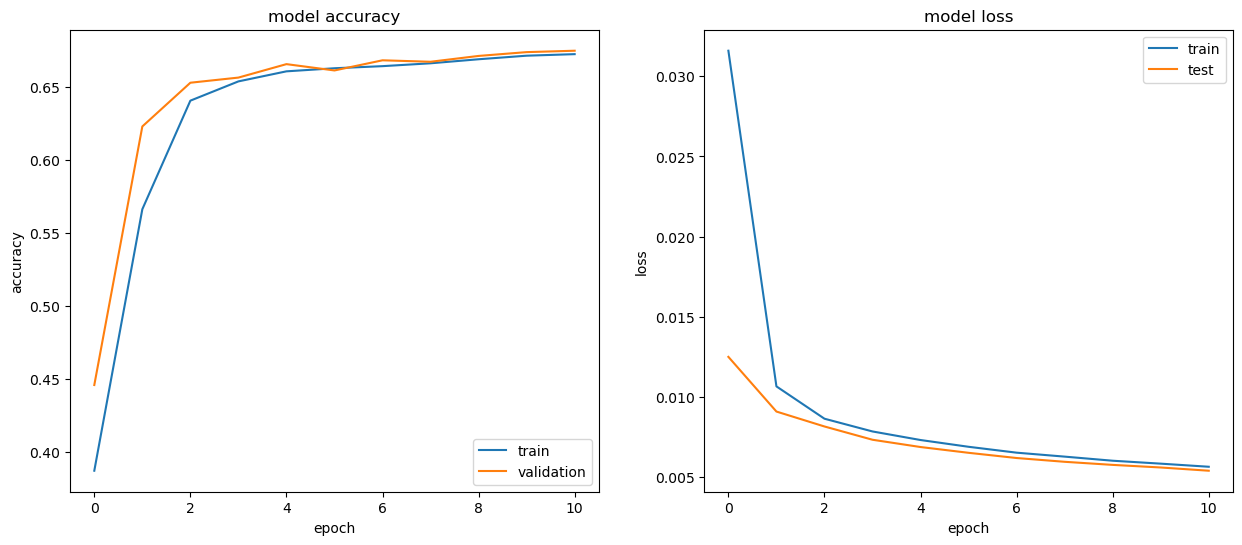

In [87]:
# Representación del loss

plot_history(history)

### 4.2. Evaluación del autoencoder

La evaluación del modelo obtenido puede hacerse en este caso tanto de forma cuantitativa (calculando el MSE entre las imágenes originales y reconstruídas del conjunto de test) como cualitativa (mostrando imágenes originales y reconstruídas).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio [1 punto]:</strong> Realizar las siguientes operaciones para evaluar las prestaciones del modelo obtenido:
    <ul>
        <li>Partiendo del conjunto de test obtenido en el primer apartado de la practica:
            <ul>
                <li>Llevar a cabo el reescalado de los datos utilizando la capa <code>normalization_layer</code> tal y como se ha hecho con los conjuntos de entrenamiento y test al inicio de este bloque.</li>
                <li>Generar el conjunto de datos <code>test_data_auto</code> en el que las imágenes sean también el objetivo y substituyan a las etiquetas. </li>
            </ul></li>
        <li>Realizar la evaluación del modelo una vez ha finalizado el entrenamiento para mostrar la pérdida y la precisión final a partir de los datos de test.</li>
        <li>Imprimir por pantalla 4 parejas de imágenes (original y reconstruída). Nota: a la hora de representar las imágenes correctamente, recordad que su rango dinámico deben ser números enteros entre 0 y 255.</li>
    </ul>
    Preguntas: ¿Consideras que la reconstrucción es adecuada? ¿Qué <i>ratio</i> de compresión se consigue con este autoencoder? Consideramos como <i>ratio</i> de compresión la relación entre el tamaño original de la imagen (224,224,3) y el de la representación más perqueña que llega a hacer el codificador (tamaño de la salida de su última capa).

In [88]:
# Normalización de los datos

normalized_test_data = test_data.map(lambda x, y: (normalization_layer(x), y))
test_data_auto = normalized_test_data.map(lambda x, y: (x, x))


In [89]:
# Evaluación del modelo

# Evaluamos el modelo 
score = model.evaluate(test_data_auto, verbose=0)

print("En los datos de test la función de pérdida es {} y en la precisión es {}, respectivamente"
      .format(round(score[0],2), round(score[1],2)))

En los datos de test la función de pérdida es 0.01 y en la precisión es 0.45, respectivamente


In [90]:
# Visualización de los datos
prediction = model.predict(test_data_auto)


33/33 [==============================] - 3s 68ms/step


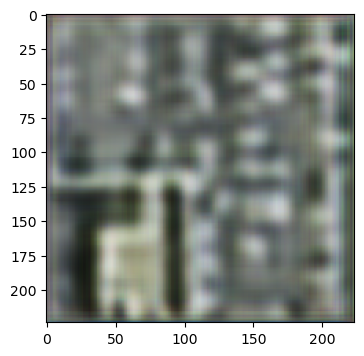

In [104]:
plt.figure(figsize=(20, 4))

plt.imshow(prediction[3])


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
En este caso podemos apreciar que el número de parámetros a entrenar es mucho menor que en los casos anteriores, pasando a tan solo 92.995 parámetros, teniendo un tiempo de entrenamiento también menor. 
    
Por otro lado vemos que la precisión del modelo es mucho mayor que en los casos anteriores, debido a que el problema es diferente
<br><br>
</div>

## 5. Red VGG16 y transfer learning (2 puntos)

Las redes neuronales convolucionales profundas nos brindan la posibilidad de mejorar la capacidad de aprendizaje de un modelo. Algunas arquitecturas comunes, pueden incluir cientos de capas convolucionales. No obstante, entrenar estas arquitecturas desde cero puede resultar costoso tanto en términos de tiempo como de recursos, además de requerir conjuntos de datos bastante grandes.

### 5.1. Transfer Learning
En este apartado, aplicaremos [transfer learning](https://keras.io/guides/transfer_learning/) con el fin de ahorrarnos parte de dicho entrenamiento. Esta metodología consiste en aprovechar los pesos de un modelo entrenado en otra base de datos y para otra tarea. En concreto, utilizaremos el modelo [VGG16](https://keras.io/api/applications/vgg/#vgg16-function) preentrenado en [Imagenet](http://www.image-net.org/), y lo adaptaremos para clasificar las 21 categorías de nuestra base de datos. En la versión de VGG16 de keras existe la opción de cargar los pesos entrenados en Imagenet sin las 3 capas totalmente conectadas de la parte final de la red (opción <code>include_top = False</code>), nosotros substituiremos esas 3 capas y reentrenaremos el conjunto con el resto de pesos congelados.

Para reutilizar el modelo correctamente es necesario preprocesar los datos tal y como se hizo durante el entrenamiento en la base de datos original. Keras nos facilita aplicar la normalización en el caso de modelos preentrenados; para el caso de VGG16 revisar la documentación de [prepocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input) (tened en cuenta que la función se aplica sobre imágenes con rango dinámico de 0 a 255).


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio[1 punto]:</strong> Implementa una red siguiendo los siguientes pasos:
    <ul>
        <li>Partir del modelo VGG16 con los pesos entrenados en Imagenet y congelarlos</li>
        <li>Substituir las 3 últimas capas completamente conectadas por 3 capas nuevas: las 2 primeras de 50 y 20 neuronas respectivamente con activación ReLU, y una última capa con el número de neuronas adecuado para llevar a cabo la tarea de clasificación sobre nuestra base de datos y la función de activación adecuada.</li> 
    </ul>
Compilar y entrenar el modelo siguiendo las siguientes indicaciones:
     <ul>
         <li>Utilizar el optimizador Adam con  <i>learning rate</i> de 0.0001.</li>
         <li>Entrenar durante 100 épocas utilizando  <i>EarlyStopping</i> con una persistencia de 10 épocas, monitorizando la <i>accuracy</i> en el conjunto de validación, y guardando los pesos que mejor resultado hayan obtenido.</li>
         <li>Monitorear la métrica  <i>accuracy</i> durante entrenamiento y validación.</li>
         <li>Mostrar las gráficas de accuracy y loss. En cada gráfica debe visualizarse la curva de entrenamiento y la de validación.</li>
         <li>Realizar la evaluación del modelo una vez ha finalizado el entrenamiento para mostrar la pérdida y la precisión final a partir de los datos de test.</li>
    </ul>
    Preguntas a responder: ¿Cúal es el número de parámetros a entrenar? ¿y el tiempo de entrenamiento? ¿Qué precisión se obtiene con este modelo? Comenta los resultados.
</div>

In [161]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model

input_layer = VGG16(include_top=False, weights='imagenet', 
                     input_shape=img_size)

# Congelamos las capas
input_layer.trainable=False

In [156]:
# Preprocesamos los datos
iterator = next(iter(train_data))
train_labels = iterator[1]
train_img = preprocess_input(iterator[0])

iterator = next(iter(val_data))
val_labels = iterator[1]
val_img = preprocess_input(iterator[0])

In [152]:
labels

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([ 4, 11,  7, 18,  5,  5, 17,  6, 13, 12,  6, 14, 15, 15, 18,  8, 18,
        8, 16,  8, 10,  0,  9,  9, 15, 10, 10, 10,  5, 15,  0,  6],
      dtype=int32)>

In [162]:
# Definición de la red

# Generamos una capa de aplanamiento de los datos que proceden de las capas convolucionales
vgg_out = input_layer.output

# Definimos una primera capa
flat_layer = Flatten()(vgg_out)
dense1_layer = Dense(50, activation='relu')(flat_layer)
dense2_layer = Dense(20, activation='relu')(dense1_layer)

# Definimos la capa final 
output_layer = Dense(num_clases, activation='softmax')(dense2_layer)
    
# Generamos el modelo 
model = Model(inputs=input_layer.input, outputs=output_layer, name="vgg_transfer")

model.summary()

Model: "vgg_transfer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

In [158]:
# Compilación de la red


model.compile(optimizer=Adam(learning_rate=l_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
             )

call = EarlyStopping(monitor='val_loss', 
                     patience=10, # Definimos la paciencia
                     verbose=1, # Mostramos si se produce un callback
                     restore_best_weights=True, # Restaura el mejor modelo
                     min_delta=0.1, # Definimos cuanto consideramos una mejoría
                     mode="min")

In [159]:
%%time

# Entrenamiento de la red
history = model.fit(train_img, train_labels, validation_data = (val_img, val_labels), epochs=100, 
                    callbacks=[call])

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 10.0747 - accuracy: 0.0312 - val_loss: 9.4055 - val_accuracy: 0.0625
Epoch 2/100
1/1 [==============================] - 0s 272ms/step - loss: 4.7812 - accuracy: 0.2188 - val_loss: 8.0737 - val_accuracy: 0.0938
Epoch 3/100
1/1 [==============================] - 0s 202ms/step - loss: 2.5802 - accuracy: 0.4375 - val_loss: 7.2124 - val_accuracy: 0.0938
Epoch 4/100
1/1 [==============================] - 0s 274ms/step - loss: 1.5495 - accuracy: 0.6250 - val_loss: 6.6666 - val_accuracy: 0.0625
Epoch 5/100
1/1 [==============================] - 0s 267ms/step - loss: 1.0879 - accuracy: 0.7188 - val_loss: 6.3074 - val_accuracy: 0.0625
Epoch 6/100
1/1 [==============================] - 0s 273ms/step - loss: 0.8429 - accuracy: 0.7812 - val_loss: 6.0962 - val_accuracy: 0.0625
Epoch 7/100
1/1 [==============================] - 0s 267ms/step - loss: 0.6901 - accuracy: 0.9062 - val_loss: 5.9912 - val_accuracy: 0.0625
Epoch 8/100
1/1

In [160]:
# Resultados

score = model.evaluate(test_data, verbose=0)


print("En los datos de test la función de pérdida es {} y en la precisión es {}, respectivamente"
      .format(round(score[0],2), round(score[1],2)))

En los datos de test la función de pérdida es 7.83 y en la precisión es 0.06, respectivamente


In [129]:
predictions = np.argmax(model.predict(test_data), axis=1)

33/33 [==============================] - 4s 91ms/step


In [140]:
predictions[3]

14

In [138]:
test_data.file_paths[3]

'../input/landuse-scene-classification/images_train_test_val/test/airplane/airplane_000111.png'

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
(Añade tus comentarios substituyendo este texto)
<br><br>
</div>

### 5.2. Fine-tunning
Una técnica frecuente, sobretodo cuando la red utilizada no es excesivamente grande (como es el caso de VGG16), para mejorar los resultados del <i>transfer learning</i> es el denominado <i>fine-tunning</i>,  que consiste en reentrenar la red completa durante unas pocas épocas y con un <i>learning rate</i> muy pequeño.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio[1 punto]:</strong> Volver a compilar el modelo con los siguientes cambios:
    <ul>
        <li>Descongelar los pesos del modelo VGG16 poniendo <code>trainable=False</code> (no confundir con <code>traning=False</code>).</li>
    </ul>
Compilar y entrenar el modelo siguiendo las siguientes indicaciones:
     <ul>
         <li>Utilizar el optimizador Adam con  <i>learning rate</i> de 0.00001.</li>
         <li>Entrenar durante 10 épocas utilizando  <i>EarlyStopping</i> con una persistencia de 10 épocas monitorizando la <i>accuracy</i> en el conjunto de validación, y guardando los pesos que mejor resultado hayan obtenido.</li>
         <li>Monitorizar la métrica  <i>accuracy</i> durante entrenamiento y validación.</li>
         <li>Mostrar las gráficas de accuracy y loss. En cada gráfica debe visualizarse la curva de entrenamiento y la de validación.</li>
         <li>Realizar la evaluación del modelo una vez ha finalizado el entrenamiento para mostrar la pérdida y la precisión final a partir de los datos de test.</li>
    </ul>
    Preguntas a responder: ¿Cúal es el número de parámetros a entrenar? ¿y el tiempo de entrenamiento? ¿Qué precisión se obtiene con este modelo? Comenta los resultados teniendo en cuenta el proceso global: <i>transfer lerning</i> + <i> fine-tunning</i>.
</div>


In [ ]:
# Definición del modelo

In [ ]:
# Compilación de la red

In [ ]:
# Entrenamiento

In [ ]:
# Resultados

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
(Añade tus comentarios substituyendo este texto)
<br><br>
</div>

## 6. Mejora de resultados (1 punto)

En este último apartado se deja libertad al alumno para conseguir, mediante el diseño de una red propia, unos mejores resultados en la tarea de clasificación.

Se valorarará la justificación de las elecciones realizadas.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio[1 punto]:</strong> Implementar un modelo para llevar a cabo la tarea de clasificación:
    <ul>
        <li>Diseñar la arquitectura de la red</li>
        <li>Compilar el modelo</li>
        <li>Llevar a cabo el entrenamientio</li>
        <li>Evaluar el modelo presentando las métricas y gráficas adecuadas</li>
        <li>Comentar los resultados obtenidos</li>
    </ul>
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
(Añade tus comentarios substituyendo este texto)
<br><br>
</div>